# Goal

Predict if a law will pass or be rejected by the votes distribution.

Once we have a trained model, we can check what are the most important features in the model and have some information of each feature is the most influential in the model which is the same thing that try to infer which senator is the most influential one.

In fact this just "copy" the code of cnn graphs of Michaël Defferrard [here](https://github.com/mdeff/cnn_graph/blob/master/usage.ipynb)

> Each law have it own policy to be approved {1/2; 3/5; ...} and the idea is try to incorporate this information in the features, as well subject, sponsored committee and sponsored party.

n = # number of laws

d = # senators

$\textbf{X}_{n\,x\,d}$ = each row is represented by a law and columns are the senator's position

$\textbf{y}_{n\,x\,1}$ = "rejected" or "passed"



## Main Takeaways - WIP



## Further Analysis

It would really cool do it for all the congress like, for instance congress 111 because the adjacency matrices are crazy ;)



In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

from lib import models, graph, coarsening, utils

/Users/lia/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/lia/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
ALL_ADJACENCY_PATH = '../data/all-votes/all_adjacency.pickle'
VOTES_115 = '../data/all-votes/votes_115.csv'
ALL_SUBJECT_PATH = '../data/all-votes/bills_20years.csv'
ALL_ADJACENCY_METRIS_PATH = '../data/all-votes/all_adjacency_metric.csv'
pal = {'republican': '#ff0000', 'democrats': '#0000ff'}

In [3]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
all_bills = pd.read_csv(ALL_SUBJECT_PATH)
all_adjacency_metrics = pd.read_csv(ALL_ADJACENCY_METRIS_PATH)
all_laws['law_id'] = all_laws['vote_uri'].apply(lambda x: '_'.join(x.split('/')[4:]).split('.')[0])
all_laws = all_laws.merge(all_bills, on='law_id', how='left')
all_laws = all_adjacency_metrics.merge(all_bills, on='law_id', how='left')
votes_115 = pd.read_csv(VOTES_115)

LOOKUP_RESULT = {
    'Agreed to': 'passed', 'Rejected': 'rejected', 'Nomination Confirmed': 'passed',
    'Cloture Motion Agreed to': 'passed', 'Amendment Rejected': 'rejected', 'Confirmed': 'passed',
    'Passed': 'passed', 'Amendment Agreed to': 'passed', 'Motion Rejected': 'rejected',
    'Motion Agreed to': 'passed', 'Bill Passed': 'passed', 'Motion to Table Agreed to': 'passed',
    'Cloture Motion Rejected': 'rejected', 'Motion to Proceed Agreed to': 'passed',
    'Cloture on the Motion to Proceed Agreed to': 'passed', 'Cloture on the Motion to Proceed Rejected': 'rejected'
}
all_laws['result_ok'] = all_laws.result.apply(lambda x: LOOKUP_RESULT.get(x, 'undefinied'))
    
print(all_laws.shape)

(6834, 33)


In [4]:
congress115 = all_laws[(all_laws['congress'] == 115) & (all_laws['result_ok'].apply(lambda x: x in ['passed', 'rejected']))]
y = congress115.result_ok.apply(lambda x: 0 if x=='rejected' else 1).values

In [5]:
(votes_115.groupby('vote_uri').size() == 100).sum() == len(votes_115) # I know, it a mess

False

In [7]:
def numeric_votes(x):
    if x == 'Yes':
        return 1
    elif x == 'Not Voting' or pd.isnull(x):
        return 0.5 # we can put np.nan and then fill with the median or mean, whatever for now
    else:
        return 0
    
members = pd.DataFrame(list(votes_115['member_id'].unique())).rename(columns={0: 'member_id'})
X = np.zeros((len(congress115), len(members)))

for i, l in enumerate(list(congress115.vote_uri)):
    votes = (members
             .merge(votes_115[votes_115.vote_uri == l], how='left')
             .sort_values(['party', 'member_id']))
    feature = votes.vote_position.apply(numeric_votes).values
    X[i] = feature

In [21]:
n_train = n // 2
n_val = n // 10

X_train = X[:n_train]
X_val   = X[n_train:n_train+n_val]
X_test  = X[n_train+n_val:]

y_train = y[:n_train]
y_val   = y[n_train:n_train+n_val]
y_test  = y[n_train+n_val:]

In [56]:
print('n = {}\nd = {}'.format(len(y), X.shape[1]))
print()
print("\x1b[31m\" We aim for an accuracy better than: {}" "\x1b[0m".format(round(y_train.sum() / y_train.shape[0], 2)))

n = 553
d = 105

" We aim for an accuracy better than: 0.78


d = |V| = 105, k|V| < |E| = 1606


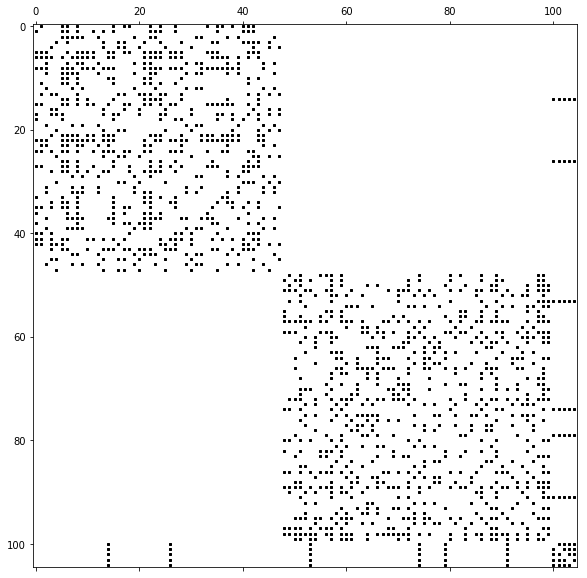

In [22]:
dist, idx = graph.distance_scipy_spatial(X_train.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)
assert A.shape == (d, d)
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
plt.figure(figsize=(10,10))
plt.spy(A, markersize=2, color='black');

In [23]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(X_test, perm)

Layer 0: M_0 = |V| = 120 nodes (15 added),|E| = 803 edges
Layer 1: M_1 = |V| = 60 nodes (5 added),|E| = 355 edges
Layer 2: M_2 = |V| = 30 nodes (2 added),|E| = 132 edges
Layer 3: M_3 = |V| = 15 nodes (0 added),|E| = 46 edges


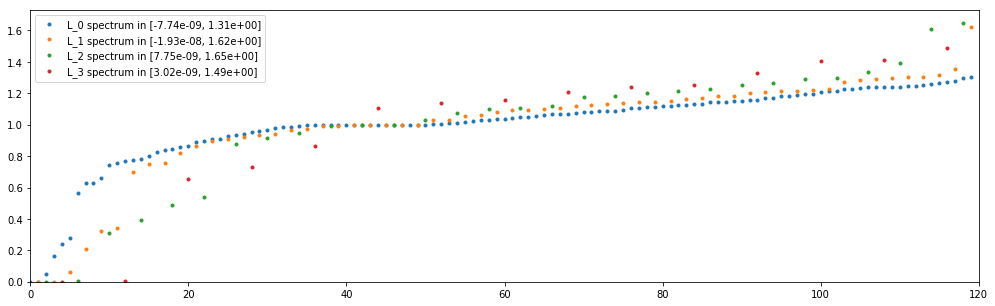

In [24]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

In [31]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 40
params['batch_size']     = 10 # changed
params['eval_frequency'] = 100 # changed

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [20, 20]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 0.5 # changed
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [32]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 120
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 120 * 32 / 4 = 960
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 30 * 64 / 2 = 960
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 960 * 512 = 491520
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 512 * 2 = 1024
    biases: M_4 = 2
step 100 / 1104 (epoch 3.62 / 40):
  learning_rate = 8.57e-04, loss_average = 1.20e+00
  validation accuracy: 90.91 (50 / 55), f1 (weighted): 90.67, loss: 1.30e+00
  time: 4s (wall 3s)
step 200 / 1104 (epoch 7.25 / 40):
  learning_rate = 6.98e-04, loss_average = 1.19e+00
  validation accuracy: 90.91 (50 / 55), f1 (weighted): 90.67, loss: 1.28e+00
  time: 9s (wall 5s)
step 300 / 1104 (epoch 10.87 / 40):
  learning_rate = 5.99e-04, loss_avera

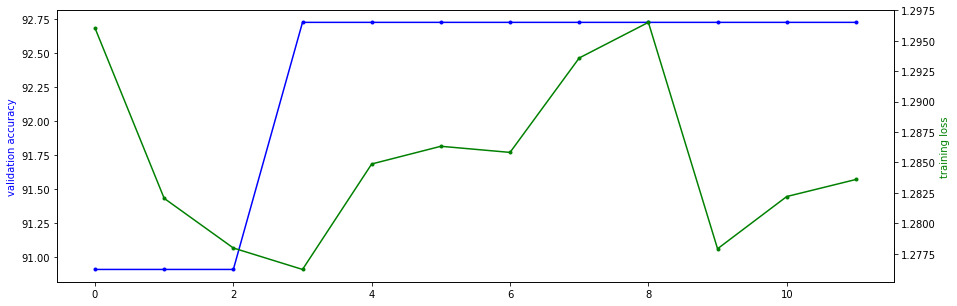

In [33]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [34]:
res = model.evaluate(X_test, y_test)
print(res[0])

INFO:tensorflow:Restoring parameters from /Users/lia/work/study/epfl/NetworkTour/US-Senators/notebooks/lib/../checkpoints/demo/model-1104
accuracy: 95.95 (213 / 222), f1 (weighted): 95.89, loss: 1.11e+00
time: 1s (wall 0s)
